### Задание для курсового проекта

#### Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Сдача проекта:

    Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
    Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
    Необходимо получить R2 > 0.6 на Private Leaderboard.
#### Укажите свой ник на kaggle - Andrey Samoryadov

#### Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#### Рекомендации для файла с кодом (ipynb):

    Файл должен содержать заголовки и комментарии
    Повторяющиеся операции лучше оформлять в виде функций
    По возможности добавлять графики, описывающие данные (около 3-5)
    Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
    Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
    Весь проект должен быть в одном скрипте (файл ipynb).
    При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
    Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.


#### Загрузка библиотек и скриптов

In [4484]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4485]:
import warnings
warnings.filterwarnings('ignore')

In [4486]:
matplotlib.rcParams.update({'font.size': 14})

#### Пути к директориям и файлам

In [4487]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

#### Описание датасета

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

#### Уменьшаем объём памяти

In [4488]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4489]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df.head(3)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750


#### Типы данных

In [4490]:
# train_df.dtypes

In [4491]:
# test_df = pd.read_csv(TEST_DATASET_PATH)
# test_df.head()

#### EDA (Exploratory Data Analysis)

#### Смотрим на целевую переменную

In [4492]:
# plt.figure(figsize = (16, 8))

# plt.subplot(121)
# train_df['Price'].hist(density=False, bins=30)
# plt.ylabel('Count')
# plt.xlabel('Price')

# plt.subplot(122)
# sns.kdeplot(train_df['Price'], shade=True, legend=False)
# plt.xlabel('Price')

# plt.suptitle('Prices distribution')
# plt.show()

In [4493]:
price_mean = round(train_df['Price'].mean(), 2)
price_median = train_df['Price'].median()
price_mode = train_df['Price'].mode()[0]

In [4494]:
price_mean, price_median, price_mode

(214138.86, 192269.66, 182938.08)

In [4495]:
# plt.figure(figsize = (16, 8))

# sns.distplot(train_df['Price'], bins=50)

# y = np.linspace(0, 0.000007, 10)
# plt.plot([price_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
# plt.plot([price_median] * 10, y, label='median', linestyle='--', linewidth=4)
# plt.plot([price_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

# plt.title('Distribution of median_house_value')
# plt.legend()
# plt.show()

#### Обзор обучающего датасета

In [4496]:
train_df.shape

(10000, 20)

#### Количественные признаки

In [4497]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### Категориальные признаки (номинативные переменные)

In [4498]:
train_df.select_dtypes(include='object').columns.tolist()

[]

In [4499]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [4500]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [4501]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### Получаем краткую сводку данных по датасету

In [4502]:
# train_df.info()

#### Смотрим, сколько пропусков

In [4503]:
# train_df.isna().sum()

### Подготовка датасета для обучения

#### Полагаю, будет целесообразно удалить признак Healthcare_1, т. к. почти половина - пропуски

In [4504]:
train_df = train_df.drop('Healthcare_1', axis=1)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,3,1,B,282078.718750


#### Преобразуем категориальные признаки Ecology_2, Ecology_3, Shops_2 в бинарные

In [4505]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750


In [4506]:
# train_df.info()

In [4507]:
# train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'int64', 'int32', 'int16', 'int8'])

In [4508]:
# train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

#### Rooms - количество комнат

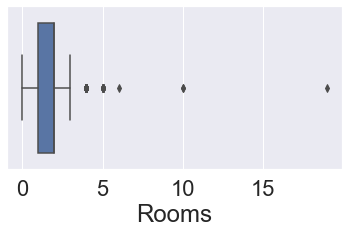

In [4509]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

In [4510]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [4511]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,0


#### Заменяем отсутствие квартир на 1, а более или равно 6 квартир на медиану

In [4512]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [4513]:
# train_df['Rooms'].value_counts()

#### KitchenSquare - площадь кухни

In [4514]:
# train_df['KitchenSquare'].value_counts()

In [4515]:
train_df['KitchenSquare'].quantile(.98), train_df['KitchenSquare'].quantile(.02)

(13.0, 0.0)

#### Заменяем все кухни из выборки от 0 до 2,5% и более 97,5% - медианой, а после кухни, площадью менее 4 м2 - на 4 м2 (вряд ли есть кухни менее 4 м2)

In [4516]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.98))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [4517]:
train_df['KitchenSquare'].value_counts()

4.0     3222
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

#### Square - площадь

In [4518]:
train_df['Square'].value_counts()

37.498161    2
65.285133    2
80.794792    2
44.482914    2
81.867165    2
            ..
63.952770    1
39.010426    1
66.681969    1
72.683846    1
35.815475    1
Name: Square, Length: 9995, dtype: int64

In [4519]:
train_df['Square'].quantile(.98), train_df['Square'].quantile(.02)

(103.62241653442385, 31.53776779174805)

In [4520]:
condition = ((train_df['Square'] < train_df['Square'].quantile(.02)) \
             | (train_df['Square'] > train_df['Square'].quantile(.98)))
train_df.loc[condition, 'Square'] = train_df['Square'].median()

In [4521]:
train_df['Square'].value_counts()

52.513309    400
80.794792      2
37.498161      2
44.482914      2
81.867165      2
            ... 
65.818504      1
65.688759      1
47.994453      1
57.267155      1
35.815475      1
Name: Square, Length: 9596, dtype: int64

In [4522]:
train_df['Square'].min()

31.53826

#### Пропуски признака LifeSquare заполним данными, полученных вычитанием из общей площади Square площади кухни KitchenSquare минус 3

In [4523]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1
# train_df.head(3)

In [4524]:
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3
# train_df.head(3)

#### Floor - этаж
#### HouseFloor - количество этажей в доме

In [4525]:
# train_df['HouseFloor'].value_counts()

In [4526]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1
# train_df

In [4527]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [4528]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
# floor_outliers

In [4529]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [4530]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [4531]:
# plt.figure(figsize = (10, 4))

# train_df['Floor'].hist(bins=30)
# plt.ylabel('Count')
# # plt.yscale(value="log")
# plt.xlabel('Floor')

# plt.title('Floor')
# plt.show()

In [4532]:
# train_df[['Floor', 'HouseFloor']].value_counts()

#### HouseYear - год постройки дома

In [4533]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [4534]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

In [4535]:
(train_df['HouseYear'] > 2021).sum()

0

#### Итоговый класс для подготовки данных

In [4536]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.98)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = 4
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

#### Смотрим корреляционную матрицу - ищем зависимости признаков друг от друга

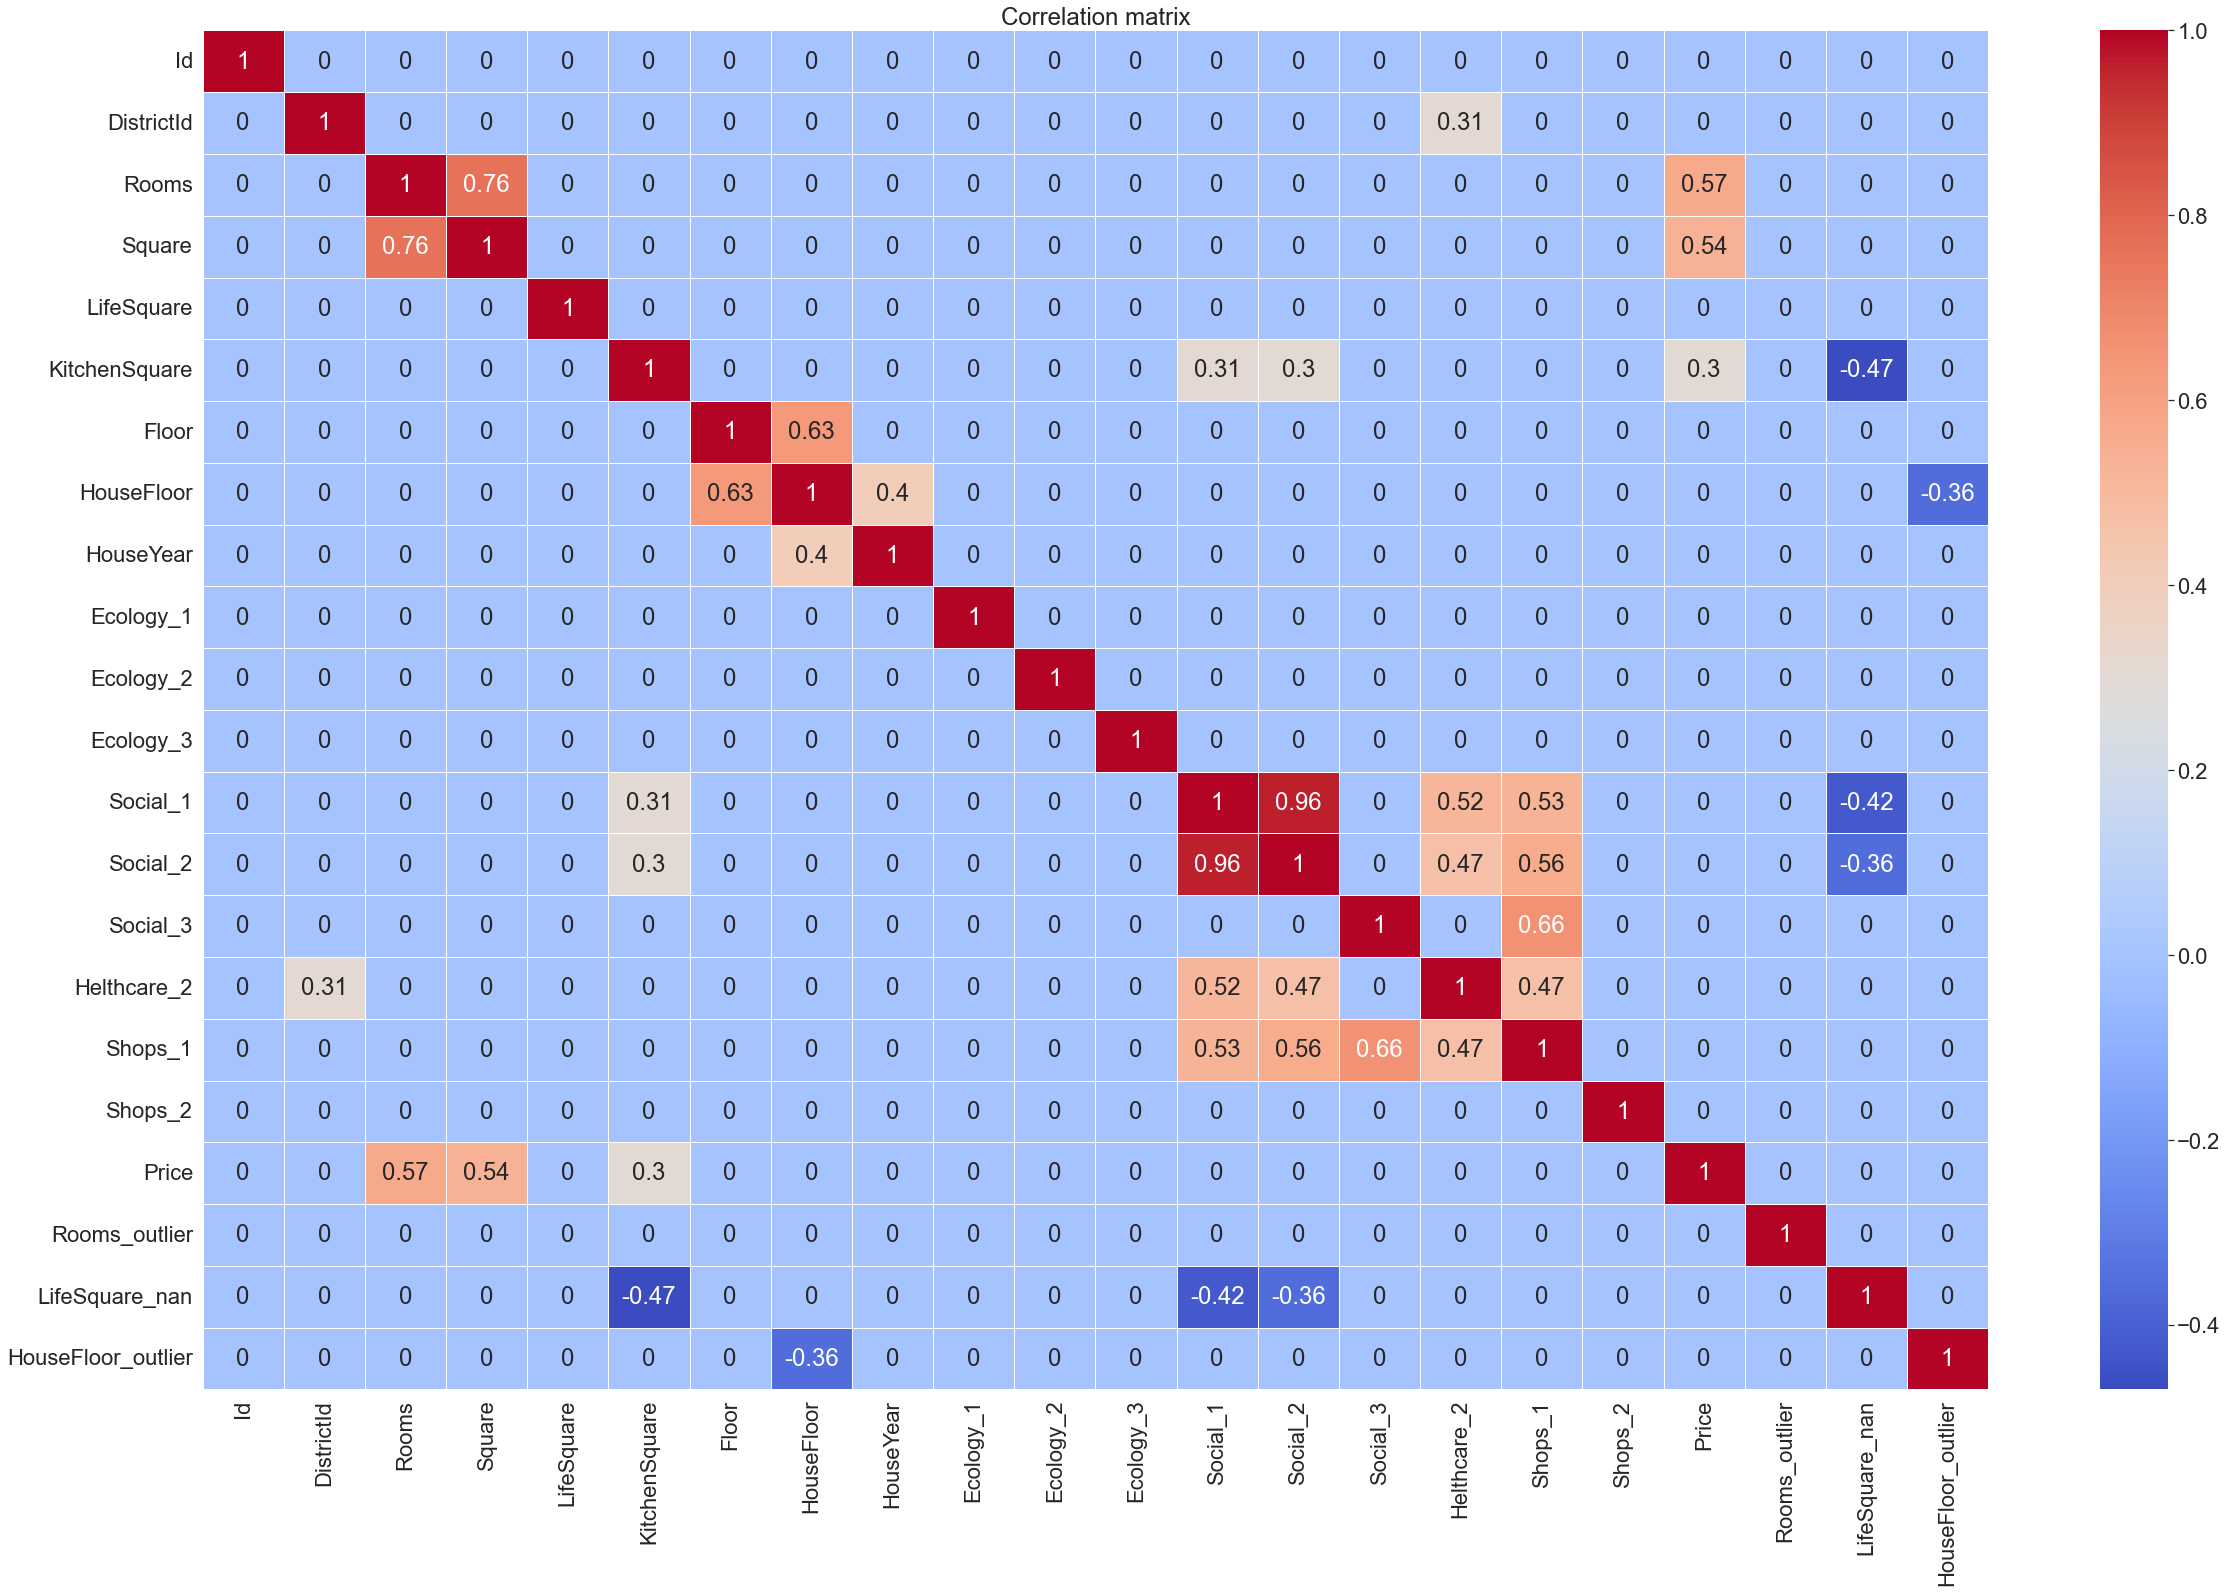

In [4537]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### И зависимости цели (цены) от признаков

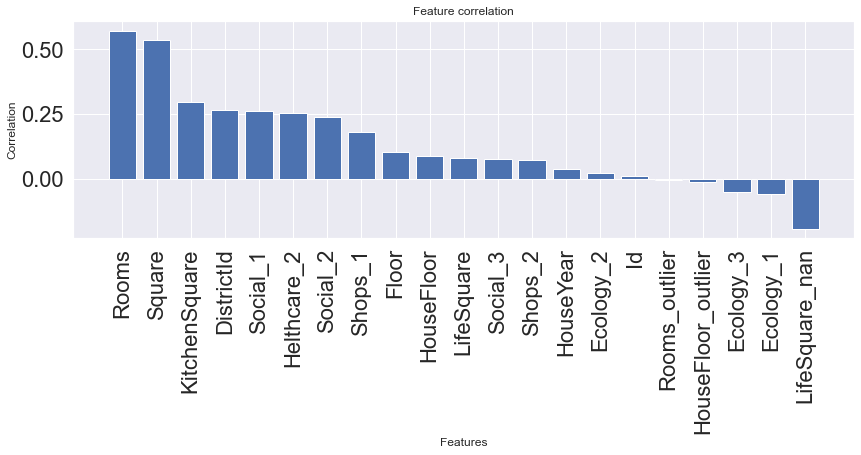

In [4538]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (14, 4))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Feature correlation', fontsize=12)
plt.show()

### Построение новых признаков

#### MedPriceByDistrict - средняя цена по районам

In [4539]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head(3)

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565


In [4540]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,52.513309,39.513309,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.875000,0,1,0,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.546875,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.718750,0,0,0,652


In [4541]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [4542]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [4543]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head(3)

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.4375
1,0,2.0,176210.8125
2,0,3.0,300610.3750


In [4544]:
med_price_by_district.shape

(667, 3)

In [4545]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,52.513309,39.513309,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.875000,0,1,0,851,1,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.546875,0,0,0,78,0,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.718750,0,0,0,652,1,244005.281250


#### MedPriceByFloorYear - средняя цена по этажу и году постройки

In [4546]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [4547]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,52.513309,39.513309,10.0,4,10.0,2014,0.075424,...,1,305018.875000,0,1,0,851,1,213530.781250,6,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,177734.546875,0,0,0,78,0,146032.828125,3,3
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,282078.718750,0,0,0,652,1,244005.281250,4,1


In [4548]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head(3)

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,362085.81250
1,1,2,324303.81250
2,1,3,429825.90625


In [4549]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,52.513309,39.513309,10.0,4,10.0,2014,0.075424,...,305018.875000,0,1,0,851,1,213530.781250,6,2,163047.09375
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,177734.546875,0,0,0,78,0,146032.828125,3,3,192968.96875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,282078.718750,0,0,0,652,1,244005.281250,4,1,208441.37500


In [4550]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).\
                                        agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков

In [4551]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'LifeSquare_nan',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [4552]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### Разбиение на train и test 

In [4553]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [4554]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [4555]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [4556]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [4557]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели 

#### Функция вывода результата

In [4558]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Первая модель - RandomForestRegressor

In [4559]:
rf_model = RandomForestRegressor(n_estimators=500, max_depth=14, max_features=10, random_state=42, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=14, max_features=10,
                      n_estimators=500, random_state=42)

Train R2:	0.948
Test R2:	0.685


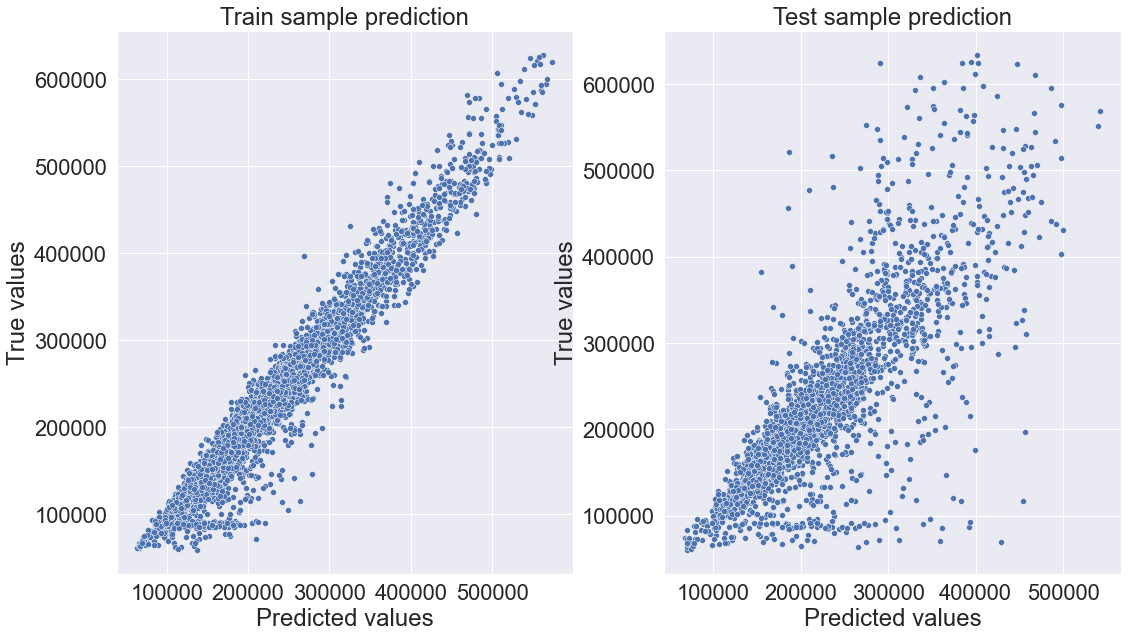

In [4560]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Модель переобучена, ищем оптимальные параметры

In [4561]:
# %%time
# params = {'n_estimators':[400, 500, 600, 700, 800], 
#           'max_depth':[8, 10, 12, 14, 16]}

# gs_rf_model = GridSearchCV(rf_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs_rf_model.fit(X_train, y_train)

In [4562]:
# gs_rf_model.best_params_
# {'max_depth': 12, 'n_estimators': 400}

#### Оптимизированная модель

In [4563]:
final_rf_model = RandomForestRegressor(n_estimators=400, max_depth=12, \
                                       max_features=10, random_state=42, criterion='mse')
final_rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=12, max_features=10,
                      n_estimators=400, random_state=42)

Train R2:	0.948
Test R2:	0.685


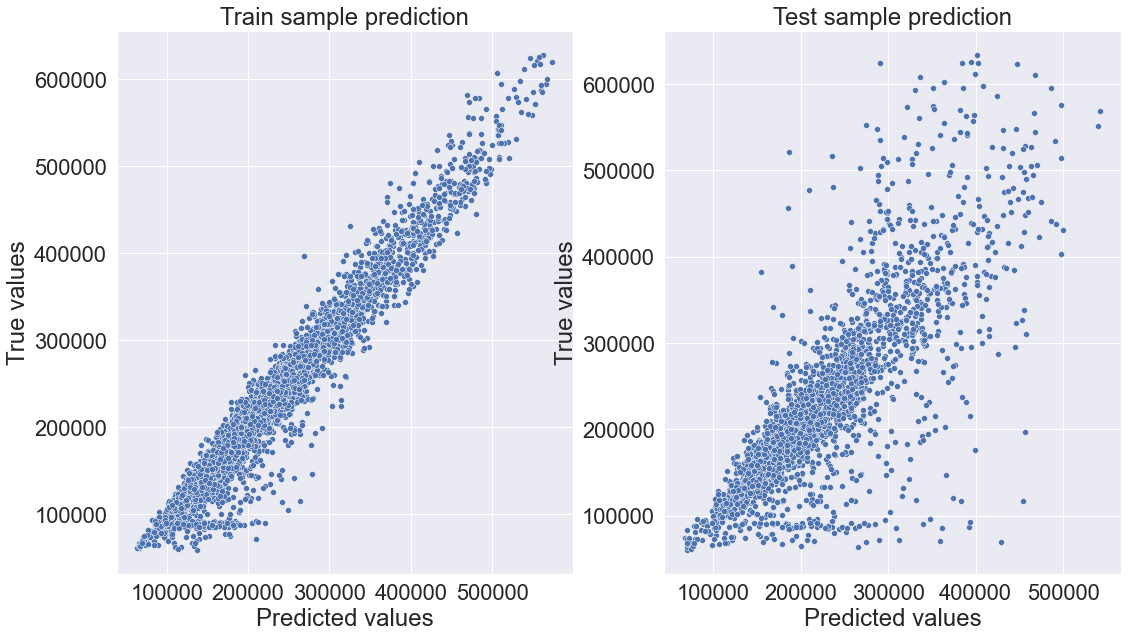

In [4564]:
y_final_train_preds = rf_model.predict(X_train)
y_final_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_final_train_preds, y_valid, y_final_test_preds)

#### Модель переобучена
---

#### Построим другую модель - GradientBoostingRegressor

Train R2:	0.921
Test R2:	0.678


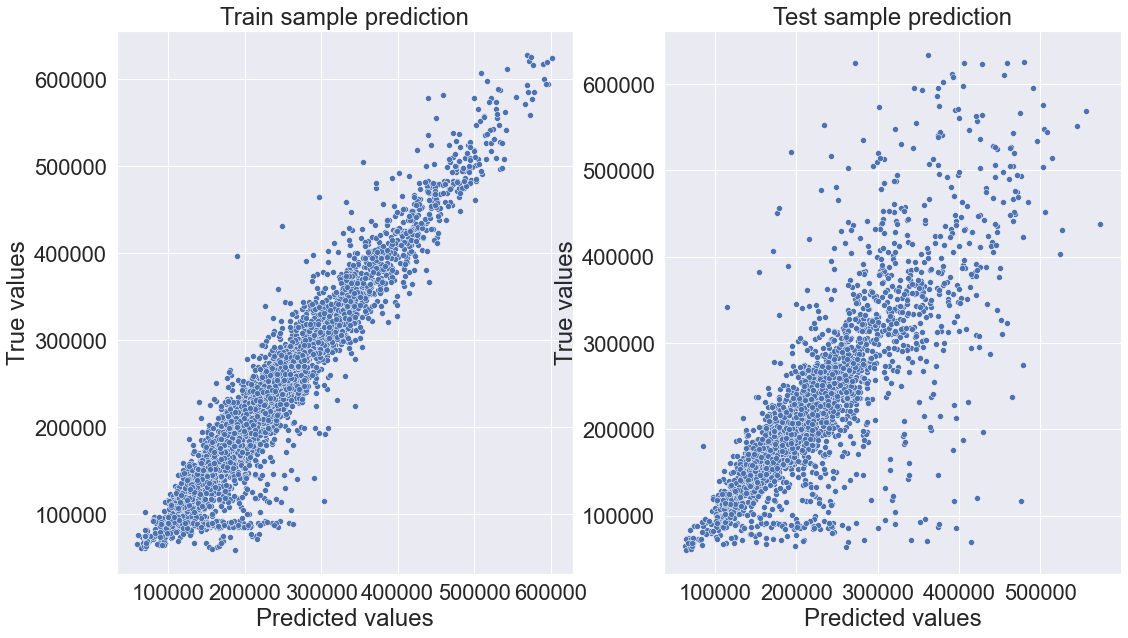

In [4565]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [4566]:
# %%time
# params = {'n_estimators':[50, 100, 200, 400], 
#           'max_depth':[3, 5, 7, 10],
#           'min_samples_leaf': [6, 8, 10, 12, 14]}

# gs_gb_model = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs_gb_model.fit(X_train, y_train)

In [4567]:
# gs_gb_model.best_params_
# {'max_depth': 3, 'min_samples_leaf': 8, 'n_estimators': 400}

#### Оптимизированная модель

Train R2:	0.865
Test R2:	0.691


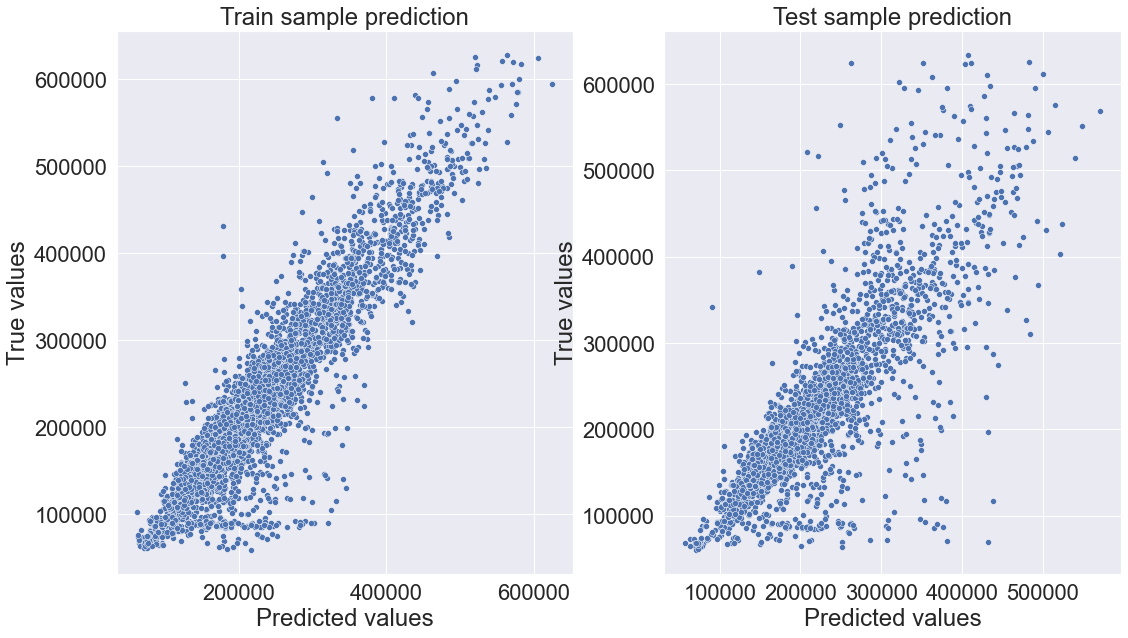

In [4568]:
final_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=3,
                                     min_samples_leaf=6,
                                     random_state=42,  
                                     n_estimators=400)
final_model.fit(X_train, y_train)

y_train_final_preds = final_model.predict(X_train)
y_test_final_preds = final_model.predict(X_valid)
evaluate_preds(y_train, y_train_final_preds, y_valid, y_test_final_preds)

#### Эта модель уже более близкая, разброс между данными (трейн и тест) сократился
---

#### Кросс-валидация

In [4569]:
cv_score = cross_val_score(final_model, X_train, y_train, scoring='r2', \
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.76013489, 0.73741469, 0.73739593, 0.76263038, 0.780037  ])

In [4570]:
cv_score.mean()

0.7555225783239369

#### Посмотрим на важность признаков

In [4571]:
final_model.feature_importances_

array([7.38935744e-03, 6.40914645e-03, 8.86093095e-03, 1.15183797e-01,
       1.16367917e-02, 1.53387196e-02, 2.45788596e-03, 1.34022596e-02,
       1.28703516e-02, 9.09527369e-03, 0.00000000e+00, 1.23200966e-04,
       1.15031789e-02, 6.41496465e-03, 1.03378149e-02, 2.18108919e-03,
       1.12027864e-03, 2.15053833e-04, 0.00000000e+00, 4.83561972e-04,
       0.00000000e+00, 0.00000000e+00, 1.99448287e-02, 0.00000000e+00,
       6.90130415e-05, 4.65196506e-04, 3.86901012e-04, 7.21186499e-01,
       2.29239049e-02])

In [4572]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [4573]:
feature_importances.head()

,feature_name,importance
27,MedPriceByDistrict,0.721186
3,Square,0.115184
28,MedPriceByFloorYear,0.022924
22,DistrictSize,0.019945
5,KitchenSquare,0.015339


---

### Попытка модели StackingRegressor (результат получился хуже, возможно упустил что-то...)

Train R2:	0.702
Test R2:	0.678


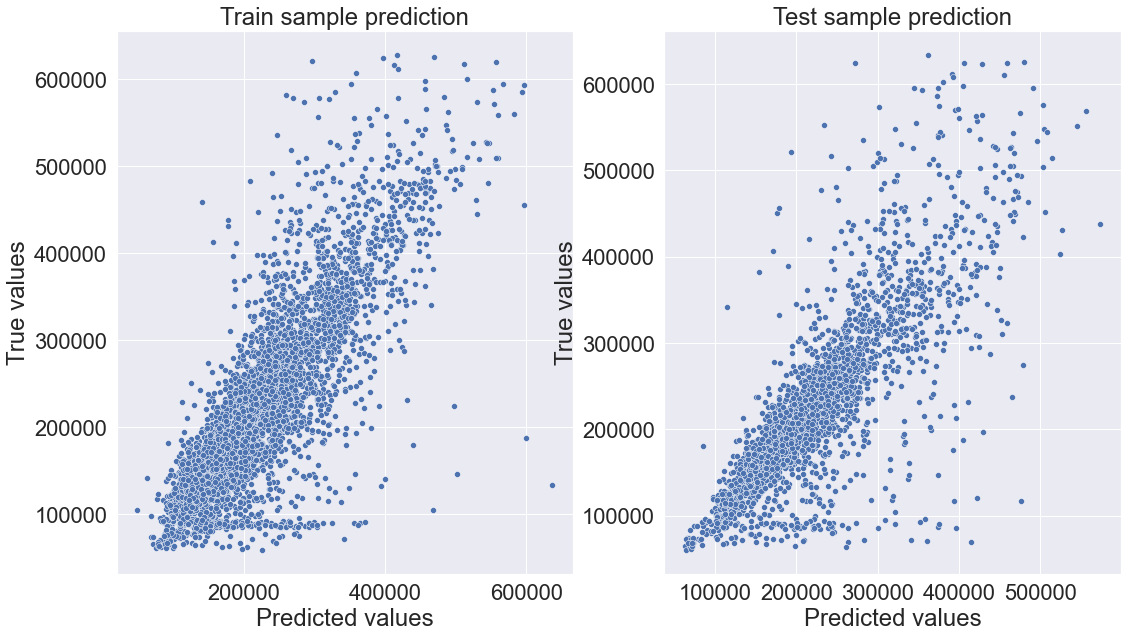

In [4574]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)

y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=700000)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [4589]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

stack = StackingRegressor([('lr', lr_model), ('rf', final_rf_model)], \
                          final_estimator=final_model, passthrough=True, n_jobs=-1)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(criterion='mse',
                                                     max_depth=12,
                                                     max_features=10,
                                                     n_estimators=400,
                                                     random_state=42))],
                  final_estimator=GradientBoostingRegressor(criterion='mse',
                                                            min_samples_leaf=6,
                                                            n_estimators=400,
                                                            random_state=42),
                  n_jobs=-1, passthrough=True)

Train R2:	0.917
Test R2:	0.686


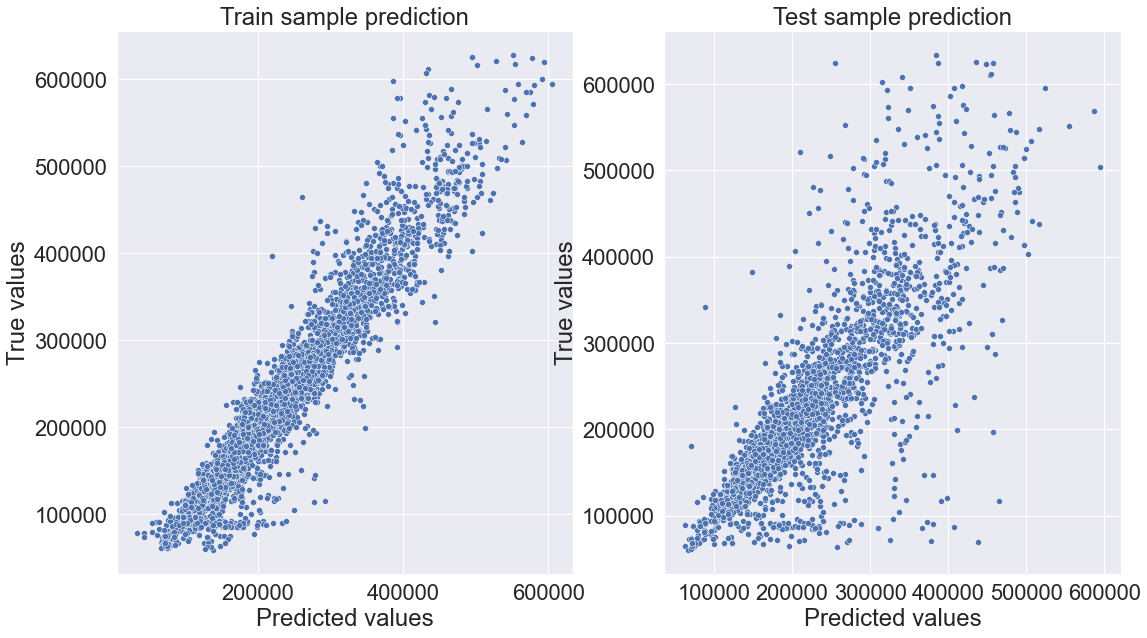

In [4590]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Предсказываем и сохраняем данные

In [4577]:
submit = pd.read_csv('sample_submission.csv')
submit.head(3)

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0


In [4578]:
predictions = final_model.predict(test_df)
predictions

array([158748.22605923, 125139.50058619, 143492.13663021, ...,
       141024.45051337, 177228.77075279, 296587.51449294])

In [4579]:
submit['Price'] = predictions
submit.head(3)

,Id,Price
0,4567,158748.226059
1,5925,125139.500586
2,960,143492.136630


In [4580]:
submit.to_csv('final_model_submit.csv', index=False)